<a href="https://colab.research.google.com/github/wbu2/BERT-Trump-vs-Biden-Classification/blob/master/BERT_President_Identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This BERT Model was based on [Chris McCormick's BERT Model](http://mccormickml.com/2019/07/22/BERT-fine-tuning/) 

# **Colab Setup**

 I will use a GPU to train this model.

 I will use the transformers package from the Hugging Face Library, a pytorch interface for using Bert.



In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [ ]:
!pip install transformers

     |████████████████████████████████| 778kB 3.5MB/s 
     |████████████████████████████████| 3.0MB 15.2MB/s 
     |████████████████████████████████| 890kB 40.1MB/s 
     |████████████████████████████████| 1.1MB 38.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=efed231a63304110d651c77bb5afe8f12c88d497f459b96ac52b36c5c4c1ef5a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# **Prepare Input**

BERT requires input to be tokenized using the included tokenizer. These tokens are mapped to their index in the vocabulary from the tokenizer.


In [ ]:
from google.colab import files
uploaded = files.upload()


In [ ]:
#Read in Pandas Dataframe containing raw tweets from Trump and Biden
import pandas as pd
import pickle
df = pd.read_pickle('/content/bert-input.pkl')
df.head()

,realDonaldTrump,JoeBiden
0,The Election will be totally rigged if Mail-I...,Women have decided the course of history with ...
1,"Because of my strong focus on the China Virus,...","Thirty years on, we still have work to do to r..."
2,"The Lamestream Media, including @FoxNews, whic...","Folks, we have just days until Election Day. ..."
3,There is NO WAY a place like Pennsylvania can ...,"In days, we have the chance to set our nation..."
4,So the Washington Post is running the Reagan F...,days.


In [ ]:
#A single Trump tweet is passed into this tokenizer to show what is done to the input
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

trump_tweets = df.realDonaldTrump.values

print(' Original: ', trump_tweets[0])

print('Tokenized: ', tokenizer.tokenize(trump_tweets[0]))

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(trump_tweets[0])))


 Original:  The  Election will be totally rigged if Mail-In Voting is allowed to take place, &amp; everyone knows it. So much time is taken talking about foreign influence, but the same people wont even discuss Mail-In election corruption. Look at Patterson, N.J. % of vote was corrupted!
Tokenized:  ['the', 'election', 'will', 'be', 'totally', 'rigged', 'if', 'mail', '-', 'in', 'voting', 'is', 'allowed', 'to', 'take', 'place', ',', '&', 'amp', ';', 'everyone', 'knows', 'it', '.', 'so', 'much', 'time', 'is', 'taken', 'talking', 'about', 'foreign', 'influence', ',', 'but', 'the', 'same', 'people', 'won', '##t', 'even', 'discuss', 'mail', '-', 'in', 'election', 'corruption', '.', 'look', 'at', 'patterson', ',', 'n', '.', 'j', '.', '%', 'of', 'vote', 'was', 'corrupted', '!']
Token IDs:  [1996, 2602, 2097, 2022, 6135, 25216, 2065, 5653, 1011, 1999, 6830, 2003, 3039, 2000, 2202, 2173, 1010, 1004, 23713, 1025, 3071, 4282, 2009, 1012, 2061, 2172, 2051, 2003, 2579, 3331, 2055, 3097, 3747, 1010

In [ ]:
#All tweets are tokenized
import pickle
t = open("/content/trump-list.pkl", "rb")
b = open("/content/joe-list.pkl", "rb")

trump_tweets = pickle.load(t)  
biden_tweets = pickle.load(b)
t.close()
b.close()
print(trump_tweets[-1])
tweet_list = trump_tweets + biden_tweets
input_ids = []
lengths = []

for tweet in tweet_list:
  encoded_sent = tokenizer.encode(tweet, add_special_tokens = True)
  input_ids.append(encoded_sent)
  lengths.append(len(encoded_sent))

print('Original: ', tweet_list[0])
print('Tokenized: ', tokenizer.tokenize(tweet_list[0]))
print('Token IDs:', input_ids[0])
print(len(trump_tweets), "Trump Tweets")
print(len(biden_tweets), "Biden Tweets")
print(len(tweet_list), "Tweets")

Newly released documents show Schiff knew all along there was no proof of Russia-Trump collusion. Wall Street Journal
Original:  The  Election will be totally rigged if Mail-In Voting is allowed to take place, &amp; everyone knows it. So much time is taken talking about foreign influence, but the same people wont even discuss Mail-In election corruption. Look at Patterson, N.J. % of vote was corrupted!
Tokenized:  ['the', 'election', 'will', 'be', 'totally', 'rigged', 'if', 'mail', '-', 'in', 'voting', 'is', 'allowed', 'to', 'take', 'place', ',', '&', 'amp', ';', 'everyone', 'knows', 'it', '.', 'so', 'much', 'time', 'is', 'taken', 'talking', 'about', 'foreign', 'influence', ',', 'but', 'the', 'same', 'people', 'won', '##t', 'even', 'discuss', 'mail', '-', 'in', 'election', 'corruption', '.', 'look', 'at', 'patterson', ',', 'n', '.', 'j', '.', '%', 'of', 'vote', 'was', 'corrupted', '!']
Token IDs: [101, 1996, 2602, 2097, 2022, 6135, 25216, 2065, 5653, 1011, 1999, 6830, 2003, 3039, 2000,

In [ ]:
import numpy as np

print('Min tweet length: ', min(lengths))
print('Median tweet length: ', np.median(lengths))
print('Max tweet length: ', max(lengths))

Min tweet length:  4
Median tweet length:  43.0
Max tweet length:  91


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0, 0.5, '# of Tweets')

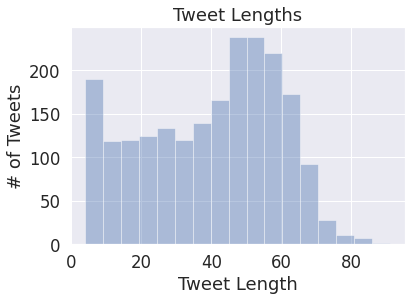

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale = 1.5)
sns.distplot(lengths, kde = False)
plt.title("Tweet Lengths")
plt.xlabel("Tweet Length")
plt.ylabel("# of Tweets")

Bert requires a constant input length. Since the tweets vary in length we will pad them with a token ID of 0

In [ ]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 110
#Pad with 0
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

Using TensorFlow backend.


In [ ]:
# Create attention masks
attention_masks = []

# For each sentence...
for tweet in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in tweet]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

#first 1045 tweets are from trump and the 1076 tweets after are biden's
labels = []
for i in range(1045):
  labels.append(0)
for i in range(1076):
  labels.append(1)

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


# **Training**

I will use BertForSequenceClassification which is the BERT model with a classification layer on top

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     60.    Elapsed: 0:00:42.

  Average training loss: 0.24
  Training epcoh took: 0:01:02

Running Validation...
  Accuracy: 0.98
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     60.    Elapsed: 0:00:41.

  Average training loss: 0.06
  Training epcoh took: 0:01:02

Running Validation...
  Accuracy: 0.98
  Validation took: 0:00:03

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     60.    Elapsed: 0:00:41.

  Average training loss: 0.04
  Training epcoh took: 0:01:02

Running Validation...
  Accuracy: 0.98
  Validation took: 0:00:03

======== Epoch 4 / 4 ========
Training...
  Batch    40  of     60.    Elapsed: 0:00:41.

  Average training loss: 0.02
  Training epcoh took: 0:01:02

Running Validation...
  Accuracy: 0.98
  Validation took: 0:00:03

Training complete!


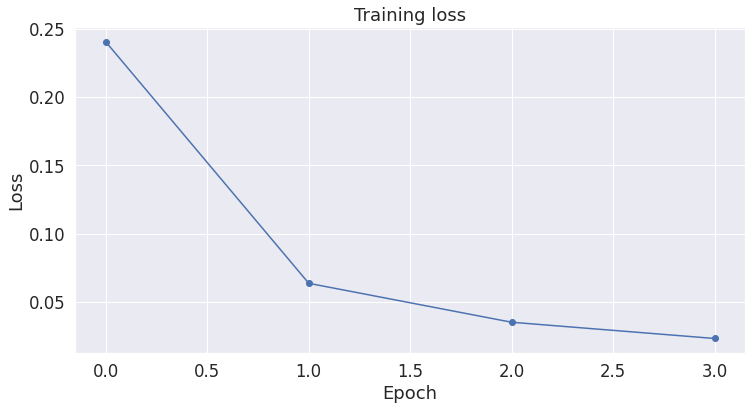

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# **Testing**

I will load test data and prepare them for input to the Bert model. To evaluate predictions, I will use Matthew's Correlation Coefficient since it is a binary classification problem. The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction.[[source: Wikipedia]](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient)



In [ ]:
import pandas as pd
import pickle

t_test = open("/content/trump-test.pkl", "rb")
b_test = open("/content/joe-test.pkl", "rb")

trump_test_tweets = pickle.load(t_test)  
biden_test_tweets = pickle.load(b_test)
used_biden_test = biden_test_tweets[0:500]
t.close()
b.close()

#Trump Data from 4/24/2020 to 5/12/2020
#Biden Data from 11/19/2019 to 2/2/2020 
print(trump_test_tweets[0])
print(trump_test_tweets[-1])
print(used_biden_test[0])
print(used_biden_test[-1])

test_data = trump_test_tweets + used_biden_test
test_labels = []
#0 is trump and 1 is biden
for i in range (223):
  test_labels.append(0)
for i in range (500):
  test_labels.append(1)

print(len(test_labels))


TRANSITION TO GREATNESS
I will never let our Post Office fail. It has been mismanaged for years, especially since the advent of the internet and modern-day technology. The people that work there are great, and we’re going to keep them happy, healthy, and well!
#TeamJoe has been hard at work making phone calls, knocking doors, and talking with as many folks as possible over the last nine months—but it all comes down to these last few days. We need all hands on deck for this final push. Sign up to volunteer today:  
When I talk about the soul of this nation—I’m talking about a country where no one has to worry about whether they can afford health care.

I fought like hell to get Obamacare passed and I’m the only one on tonight’s stage who has led a transformation of our health care system.
723


In [ ]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []

# For every sentence...
for tweet in test_data:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        tweet,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test tweets...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 723 test tweets...
    DONE.


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.943


# **Conclusion**

Using my trained Bert model for sequence classification, I was able to obtain a MCC of 0.943 which is near perfect. My model trained on tweets from Trump and Biden's timelines was able to accrurately predict whether a given tweet was Trump's or Biden's.